In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from dataset_HR import AdSBHDataset
from model_HR import AdSBHNet
from constants import dreal, dcomplex

# Import dataset

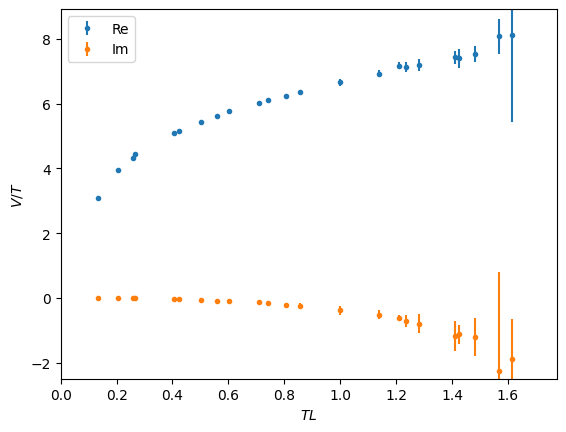

In [2]:
dataset = AdSBHDataset(file='1607latticeT290.txt') # originally the data file here was lattice.txt
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

Right now we can't solve for the `curve` for that high $T L$ so we'll drop some data points.

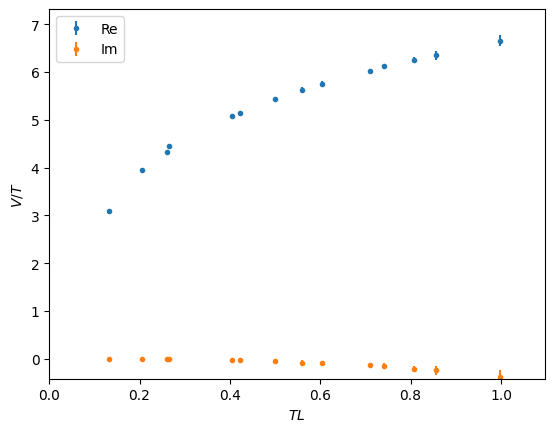

In [3]:
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# Initialize model

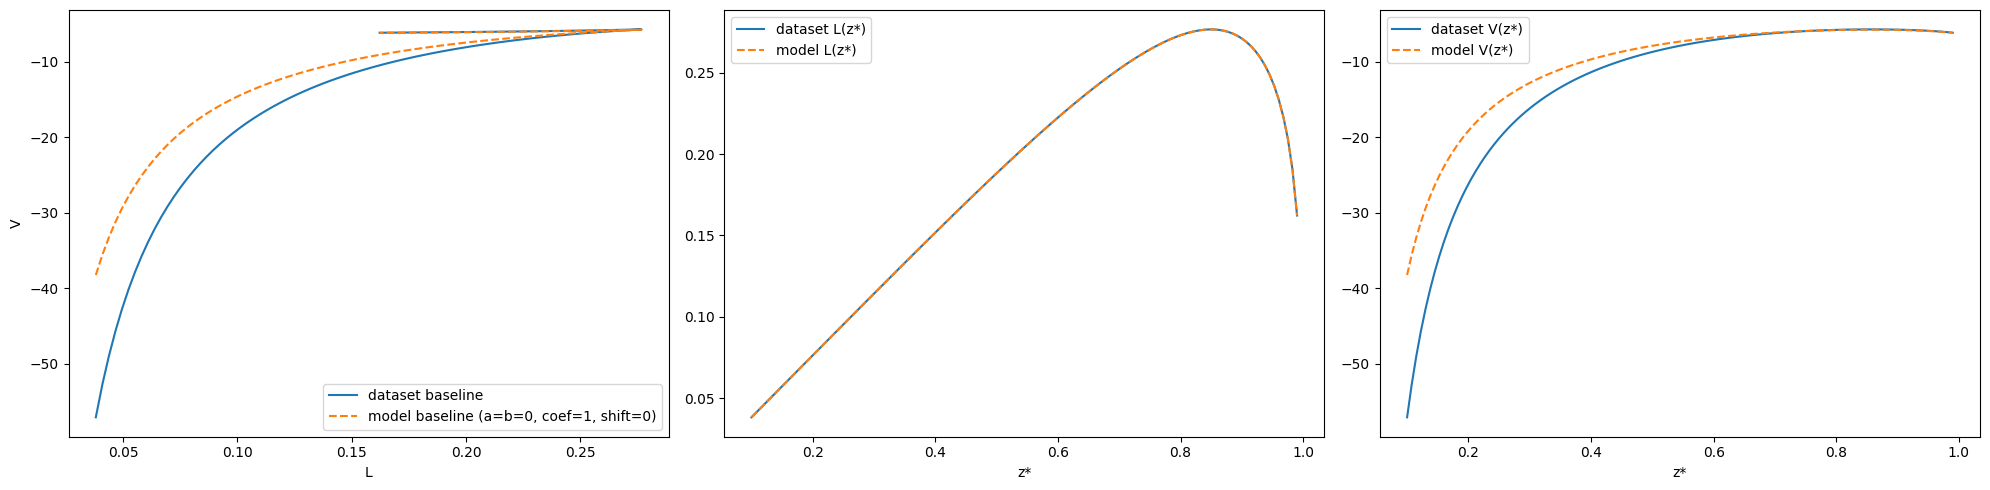

In [4]:
model = AdSBHNet(N=4, std=0.5)

# 1) initialize the model to AdS-BH baseline
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    model.logcoef.copy_(torch.tensor(0.0, dtype=model.logcoef.dtype, device=model.logcoef.device))  # exp(0)=1
    model.shift.copy_(torch.tensor(0.0, dtype=model.shift.dtype, device=model.shift.device))

# 2) sample a shared zs-grid and compute L(z*), V(z*) with the SAME conventions
zs = np.linspace(0.10, 0.99, 120, dtype=float)

# dataset (baseline)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])

# model (now baseline)
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])

# 3) plots: they should now overlay (up to small quadrature noise)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(d_L, d_V, label='dataset baseline')
axs[0].plot(m_L, m_V, '--', label='model baseline (a=b=0, coef=1, shift=0)')
axs[0].set_xlabel('L'); axs[0].set_ylabel('V'); axs[0].legend()

axs[1].plot(zs, d_L, label='dataset L(z*)'); axs[1].plot(zs, m_L, '--', label='model L(z*)')
axs[1].set_xlabel('z*'); axs[1].legend()

axs[2].plot(zs, d_V, label='dataset V(z*)'); axs[2].plot(zs, m_V, '--', label='model V(z*)')
axs[2].set_xlabel('z*'); axs[2].legend()

plt.tight_layout()


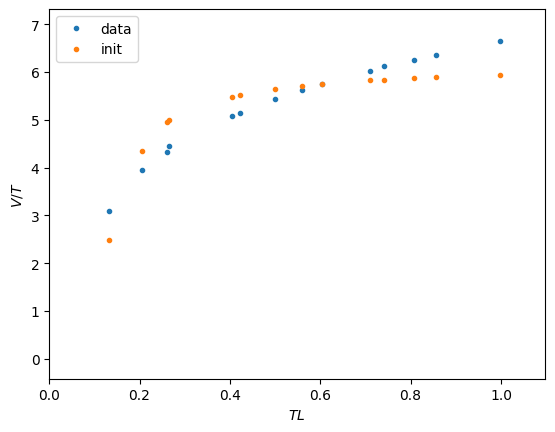

In [7]:

with torch.no_grad():
    # Note that V_pred is proportional to `coef`.
    x = model(dataset.L).real.reshape(-1, 1) / model.logcoef.exp()
    x = x.numpy()
    y = dataset.V.real.numpy()
    fit = LinearRegression().fit(x, y)
    # Set `logcoef` and `shift` to the linear fit values
    model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    model.shift = nn.Parameter(torch.tensor(fit.intercept_, dtype=dreal))
plt.plot(dataset.L, y, '.', label='data')
plt.plot(dataset.L, fit.coef_ * x + fit.intercept_, '.', label='init')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

It is advisable to try choosing reasonable initial values for `logcoef` and `shift` to help learning.

# Robust initialization

Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True)
LinearRegression()


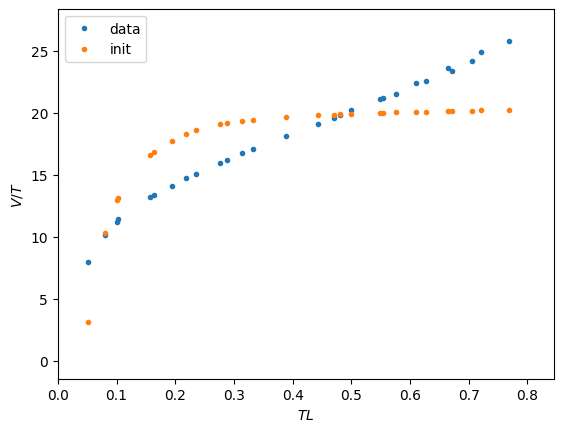

In [5]:
print(model.logcoef)
with torch.no_grad():
    # Note that V_pred is proportional to `coef`.
    #coefnow = nn.Parameter(torch.tensor(0.15089977670036966,dtype=dreal).log())
    #model.logcoef = coefnow
    x = model(dataset.L).real.reshape(-1, 1) /model.logcoef.exp()
    x = x.numpy()
    y = dataset.V.real.numpy()
    fit = LinearRegression().fit(x, y)
    print(fit)
    # Set `logcoef` and `shift` to the linear fit values
    # previously model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    #model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    model.shift = nn.Parameter(torch.tensor(fit.intercept_, dtype=dreal))
plt.plot(dataset.L, y, '.', label='data')
#plt.plot(dataset.L, model.logcoef * x + fit.intercept_, '.', label='init')
plt.plot(dataset.L, fit.coef_ * x + fit.intercept_, '.', label='init')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# The new training loop:

In [9]:

torch.set_grad_enabled(True)

def V_of_L_interp_diff(model, L_query,
                       zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7, eps=1e-12,
                       min_tail_slope=None):  # optionally force a small positive tail slope
    """
    FULL V(L) (connected - counterterm), NO shift.
    Real connected branch only; linear interp inside; linear tail outside
    using a ROBUST slope estimate from the last window of real points.
    """
    dev, dt = model.a.device, model.a.dtype
    Lq = torch.as_tensor(L_query, dtype=dt, device=dev).reshape(-1)

    # power-mapped z* grid, dense near UV and close to horizon
    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)

    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    # sort by L and keep strictly increasing part
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    Lm, Vm = Lc[keep], Vc[keep]

    if Lm.numel() < 5:
        # fallback
        return torch.full_like(Lq, float('nan'))

    # --- robust tail slope from a window at the right edge
    W = min(20, Lm.numel()-1)
    xw = Lm[-W:]
    yw = Vm[-W:]
    # least-squares slope
    xw_mean = xw.mean()
    yw_mean = yw.mean()
    num = ((xw - xw_mean) * (yw - yw_mean)).sum()
    den = ((xw - xw_mean)**2).sum().clamp_min(eps)
    mR = num / den

    if min_tail_slope is not None:
        mR = torch.maximum(mR, torch.tensor(min_tail_slope, dtype=dt, device=dev))

    # left slope also a bit more robust
    WL = min(10, Lm.numel()-1)
    xL, yL = Lm[:WL], Vm[:WL]
    xL_mean, yL_mean = xL.mean(), yL.mean()
    numL = ((xL - xL_mean) * (yL - yL_mean)).sum()
    denL = ((xL - xL_mean)**2).sum().clamp_min(eps)
    mL = numL / denL

    # linear interp inside support
    pos = torch.searchsorted(Lm, Lq, right=True)
    i0  = (pos-1).clamp(0, Lm.numel()-2)
    i1  = i0 + 1
    x0, x1 = Lm[i0], Lm[i1]
    y0, y1 = Vm[i0], Vm[i1]
    w = (Lq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1 - y0)

    # linear extrapolation outside with robust slopes
    v_left  = Vm[0]  + mL * (Lq - Lm[0])
    v_right = Vm[-1] + mR * (Lq - Lm[-1])

    v = torch.where(Lq <  Lm[0],  v_left,  v_lin)
    v = torch.where(Lq >  Lm[-1], v_right, v)

    return v


# ---- smoothness regularizer (C2 finite-difference)
def smoothness_C2(val_fn, z):
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()

# ---- tiny UV/IR priors (soft)
def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995,  dtype=model.a.dtype, device=model.a.device)
    f0   = model.eval_f(z0).real
    g0   = model.eval_g(z0).real
    fhor = model.eval_f(zh).real
    return (f0-1.0)**2 + (g0-1.0)**2 + (fhor-0.0)**2

# ---- make sure a,b aren’t exactly zero (helps grads)
with torch.no_grad():
    if torch.allclose(model.a, torch.zeros_like(model.a)): model.a.normal_(0.0, 5e-4)
    if torch.allclose(model.b, torch.zeros_like(model.b)): model.b.normal_(0.0, 5e-4)

# ---- dataloader
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10, shuffle=True, drop_last=False)

# ---- optimizer (AdamW) with higher LR for shift, small LR for coef
opt = torch.optim.AdamW([
    {'params': [model.a],      'lr': 2e-2,  'weight_decay': 5e-5},
    {'params': [model.b],      'lr': 8e-3,  'weight_decay': 5e-5},
    {'params': [model.shift],  'lr': 6e-2,  'weight_decay': 0.0},   # let shift move
    {'params': [model.logcoef],'lr': 6e-4,  'weight_decay': 0.0},
], betas=(0.9, 0.999))

# ---- cosine anneal
EPOCHS = 100
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=2e-4)

# ---- regularization weights
lam_a_L2, lam_b_L2 = 4e-4, 6e-4
lam_a_C2, lam_b_C2 = 9e-4, 7e-4
lam_phy = 3e-3
z_reg  = torch.linspace(1e-3, 0.99, 220, dtype=model.a.dtype, device=model.a.device)

# ---- snapshot arrays (monitor)
snap_every = max(1, EPOCHS // 40)
snap_a, snap_b, snap_coef, snap_shift = [], [], [], []
def _snapshot():
    snap_a.append(model.a.detach().cpu().numpy().copy())
    snap_b.append(model.b.detach().cpu().numpy().copy())
    snap_coef.append(model.logcoef.exp().item())
    snap_shift.append(model.shift.item())

_snapshot()  # initial

# ---- training loop
eps = 1e-12
USE_IMAG = False   # keep False for now (real-only training)

for epoch in range(1, EPOCHS+1):
    for L, V, sigma in loader:
        opt.zero_grad()

        # FULL model (connected - ct), then add shift
        V_core = V_of_L_interp_diff(model, L, zs_num=1000)
        V_pred = V_core + model.shift

        r_re = V_pred - V.real
        if USE_IMAG:
            r_im = torch.zeros_like(r_re) - V.imag
        else:
            r_im = torch.zeros_like(r_re)

        # weights and mild large-L emphasis (don’t over-emphasize UV)
        w_re = torch.clamp(1.0/(sigma.real**2 + eps), max=1e6)
        wL   = (L / dataset.L.max()).clamp_min(0).pow(1.25)

        loss_re = (w_re * wL * r_re**2).mean()
        loss_im = 0.0 * (r_im**2).mean()

        reg_L2 = lam_a_L2*(model.a.real**2).sum() + lam_b_L2*(model.b.real**2).sum()
        reg_C2 = lam_a_C2*smoothness_C2(model.eval_a, z_reg) + lam_b_C2*smoothness_C2(model.eval_b, z_reg)
        reg_phy = lam_phy * uv_horizon_penalty(model)

        loss = loss_re + loss_im + reg_L2 + reg_C2 + reg_phy
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # --- shift nudge (faster vertical alignment)
        with torch.no_grad():
            num = (w_re*wL * (V.real - V_core)).sum()
            den = (w_re*wL).sum().clamp_min(1e-8)
            target_shift = (num/den).item()
            model.shift.add_(0.25 * (target_shift - model.shift.item()))

    sched.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | loss={loss.item():.4e} | Re={loss_re.item():.4e} | "
              f"L2={reg_L2.item():.2e} C2={reg_C2.item():.2e} PHY={reg_phy.item():.2e} | "
              f"shift={model.shift.item():.3f} coef={model.logcoef.exp().item():.3e}")

    if epoch % snap_every == 0 or epoch == EPOCHS:
        _snapshot()

# ======== Final plots ========

# (A) Full parametric curve (real branch). For *display*, clip y to [-4, +∞)
with torch.no_grad():
    zs = torch.linspace(0.06, 0.995, 1000, dtype=model.a.dtype, device=model.a.device)
    L_curve = model.integrate_L(zs).real
    V_curve = model.integrate_V(zs).real + model.shift

    idx = torch.argsort(L_curve)
    Ls  = L_curve[idx]; Vs = V_curve[idx]
    keep = torch.cat([torch.tensor([True], device=Ls.device), torch.diff(Ls) > 0])
    Ls, Vs = Ls[keep], Vs[keep]

# ---- display clipping only (does not affect training/model)
Vs_disp = torch.maximum(Vs, torch.tensor(-4.0, dtype=Vs.dtype, device=Vs.device))

plt.figure(figsize=(6.5,4.8))
plt.plot(Ls.cpu().numpy(), Vs_disp.cpu().numpy(), '-', label='model: full $V(L)$ (display ≥ -4)')
plt.errorbar(dataset.L.cpu().numpy(), dataset.V.real.cpu().numpy(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None),
             fmt='.', label='data (Re)')
plt.xlabel('L'); plt.ylabel('V'); plt.ylim(-4, None); plt.legend(); plt.tight_layout()

# (B) Parameter snapshots
sa, sb = np.array(snap_a), np.array(snap_b)
plt.figure(figsize=(6.8,4.2))
for i in range(sa.shape[1]): plt.plot(sa[:,i], label=f'a[{i}]')
for i in range(sb.shape[1]): plt.plot(sb[:,i], '--', label=f'b[{i}]')
plt.xlabel('snapshot step'); plt.ylabel('value'); plt.legend(ncol=2, fontsize=8); plt.tight_layout()

print(f"Final shift = {model.shift.item():.4f},  coef = {model.logcoef.exp().item():.6g}")


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

Parameter containing:
tensor(23.4596, dtype=torch.float64, requires_grad=True)


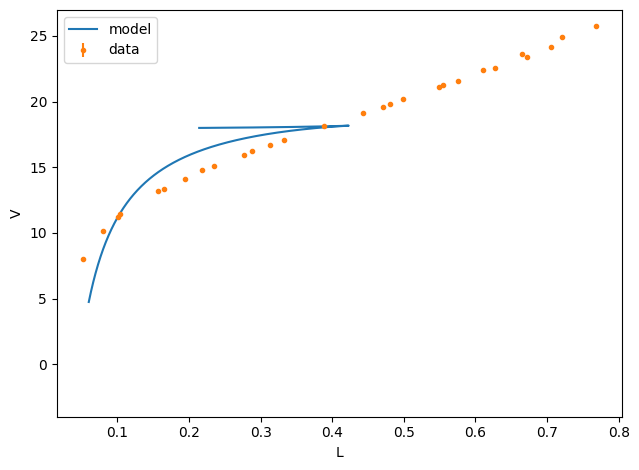

In [7]:
with torch.no_grad():
    zs = torch.linspace(0.10, 0.995, 1200, dtype=model.a.dtype, device=model.a.device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift  # constant disconnected via shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lc.cpu(), Vc.cpu(), '-', label='model')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='.', label='data')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()
print(model.shift)


In [11]:
# ==== Print final a_i, b_i coefficients ====

@torch.no_grad()
def print_ab(model):
    a = model.a.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Plain readable print
    print("a:", ", ".join([f"a{i} = {a[i]:.10g}" for i in range(len(a))]))
    print("b:", ", ".join([f"b{i} = {b[i]:.10g}" for i in range(len(b))]))

    # Mathematica-friendly rows (copy/paste)
    print("\n(* Mathematica lists *)")
    print("{", ", ".join([f"{x:.17g}" for x in a]), "},  (* a0..aN *)")
    print("{", ", ".join([f"{x:.17g}" for x in b]), "},  (* b0..bN *)")

print_ab(model)

a: a0 = -8.892229101e-05, a1 = 0.582579514, a2 = 0.688194202, a3 = 0.6772551678
b: b0 = 0.004555200842, b1 = 0.244654406, b2 = 0.2412761736, b3 = 0.2384454666

(* Mathematica lists *)
{ -8.8922291010748363e-05, 0.58257951398007013, 0.68819420199904624, 0.67725516779102068 },  (* a0..aN *)
{ 0.0045552008416426424, 0.24465440600168342, 0.24127617360343942, 0.2384454665891306 },  (* b0..bN *)


Export the data for each temperature as structure with following columns
[1] = z_*
[2] = f(z_*)
[3] = g(z_*)
[4] = l(z_*)
[5] = V(z_*)
We do this separately for real and imaginary cases of z_*

In [29]:
# for real z_*
for zs in np.linspace(0.01,0.99,100):
    print('{',zs,',',model.eval_f(zs).detach().numpy(),',',model.eval_g(zs).detach().numpy(),',',np.real(model.integrate_L(zs).detach().numpy()),',',np.real(model.integrate_V(zs).detach().numpy())[0],'},')

{ 0.01 , 0.9999984834046913 , 1.0001597425660675 , 0.003814024964185944 , -59.06373752419402 },
{ 0.0198989898989899 , 0.9999880338740377 , 1.0005807008101686 , 0.007590663114771748 , -29.100808738540948 },
{ 0.029797979797979796 , 0.9999597680761917 , 1.0012869947214134 , 0.011369513357756003 , -19.37280308886287 },
{ 0.039696969696969696 , 0.9999047668248014 , 1.0023036607665503 , 0.015151717584853152 , -14.518507157148239 },
{ 0.049595959595959596 , 0.9998140852346946 , 1.0036569849738695 , 0.018938489542845438 , -11.603346659091496 },
{ 0.059494949494949496 , 0.9996787641743372 , 1.0053744896781742 , 0.022731120131870997 , -9.656691273557037 },
{ 0.06939393939393938 , 0.999489842984679 , 1.0074849312367802 , 0.02653098239227908 , -8.263369250322793 },
{ 0.07929292929292929 , 0.9992383734265899 , 1.0100183090857824 , 0.03033953621311064 , -7.215889597241065 },
{ 0.08919191919191918 , 0.9989154348095668 , 1.0130058864691875 , 0.034158332794340135 , -6.398976548530476 },
{ 0.099090909

In [30]:
# for imaginary z_*
for zs in model.curve_zs[1:]:
    print('{',zs,',',np.real(model.eval_f(zs).detach().numpy()),',',np.real(model.eval_g(zs).detach().numpy()),',',np.real(model.integrate_L(zs).detach().numpy()),',',np.real(model.integrate_V(zs).detach().numpy())[0],'},')

{ (0.851421211220324+0j) , 0.3840515 , 8.57237 , 0.5271845104339283 , 0.32204790670048555 },
{ (0.8533638131776088+0.034942416706021814j) , 0.38445312 , 8.619831 , 0.5366408202448532 , 0.33396116247333785 },
{ (0.8552481645293581+0.04916523306340127j) , 0.38494748 , 8.674983 , 0.5460971300166613 , 0.34572951313822387 },
{ (0.8570765169045672+0.059913855658290195j) , 0.38553116 , 8.737351 , 0.5555534406680855 , 0.3573600007776634 },
{ (0.8588510247245511+0.06884175795075675j) , 0.386201 , 8.806464 , 0.5650097496725508 , 0.3688592213130173 },
{ (0.8605737371396672+0.07659362298423344j) , 0.3869535 , 8.881923 , 0.5744660594030898 , 0.3802333738112891 },
{ (0.8622466176952487+0.08350218816353322j) , 0.38778508 , 8.963355 , 0.5839223691850771 , 0.3914882775044828 },
{ (0.8638715421736469+0.08976634902157148j) , 0.38869312 , 9.050407 , 0.5933786789743185 , 0.4026294064554463 },
{ (0.8654503040068284+0.09551648787435749j) , 0.38967404 , 9.142778 , 0.602834988765011 , 0.41366191418822873 },
{ 

TO DO:

- pieni lämpötila: muuttaa reunaehtoja sikarigeometrian mukaisesti?
- WL jälkeen muut kysymykse: BH horizon area? -> QFT entropy saadusta metriikasta
- entropian jälkeen null-energy conditions (NEC): meillä on Einsteinin yhtälö, 
- entropian laskemisen jälkeen pitäisi löytää entropian dataa jostain johon verrata
- energia-momenttitensori --> äänen nopeus (tensorin komponentit kts. 1707.80521.pdf)

# Trail and error hunting: cell A

In [6]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    dev, dt = model.a.device, model.a.dtype
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]

@torch.no_grad()
def _sample_real_branch(model, zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7):
    """Return strictly-monotone (L, V) for the *real, connected* branch (FULL V: conn-ct with current scale)."""
    dev, dt = model.a.device, model.a.dtype
    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    return Lc[keep], Vc[keep]  # FULL V, NO shift

@torch.no_grad()
def _interp_1d(x, y, xq, eps=1e-12):
    """Vectorized linear interpolation with linear extrapolation on both ends (no gradients)."""
    dt, dev = x.dtype, x.device           # <-- correct order
    xq = torch.as_tensor(xq, dtype=dt, device=dev).reshape(-1)
    pos = torch.searchsorted(x, xq, right=True)
    i0 = (pos-1).clamp(0, x.numel()-2); i1 = i0+1
    x0, x1 = x[i0], x[i1]; y0, y1 = y[i0], y[i1]
    w  = (xq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1 - y0)
    mL = (y[1]-y[0])/(x[1]-x[0]+eps)
    mR = (y[-1]-y[-2])/(x[-1]-x[-2]+eps)
    v_left  = y[0]  + mL*(xq - x[0])
    v_right = y[-1] + mR*(xq - x[-1])
    v = torch.where(xq <  x[0],  v_left,  v_lin)
    v = torch.where(xq >  x[-1], v_right, v)
    return v

# ---- INIT (scale + shift) ----
with torch.no_grad():
    Lm, Vm_full = _sample_real_branch(model)  # tensors on device/dtype of model

    # cast dataset to the same device/dtype
    Ld = dataset.L.to(device=Lm.device, dtype=Lm.dtype)
    Vd = dataset.V.real.to(device=Lm.device, dtype=Lm.dtype)

    # only in-support points
    mask = (Ld >= Lm[0]) & (Ld <= Lm[-1])
    if mask.sum() < 3:
        print("Init: too few in-support points. Increase zs_num or adjust zmin/zmax.")
    L_fit = Ld[mask]
    Y_fit = Vd[mask]

    # model at those L using the SAME path
    X_fit_full = _interp_1d(Lm, Vm_full, L_fit)               # FULL V (with current scale), NO shift

    # remove current scale before LS so new slope becomes the global scale
    X_fit = (X_fit_full / model.logcoef.exp())

    # LS: Y ≈ slope * X + shift
    x_np = X_fit.detach().cpu().numpy().reshape(-1,1)
    y_np = Y_fit.detach().cpu().numpy()
    fit = LinearRegression().fit(x_np, y_np)
    slope = max(float(fit.coef_[0]), 1e-12)
    shift = float(fit.intercept_)

    # write back
    model.logcoef = torch.nn.Parameter(torch.tensor(np.log(slope), dtype=model.a.dtype, device=model.a.device))
    model.shift   = torch.nn.Parameter(torch.tensor(shift,        dtype=model.a.dtype, device=model.a.device))

# ---- quick visual check (only in-support) ----
with torch.no_grad():
    Lm, Vm_full = _sample_real_branch(model)
    Ld = dataset.L.to(device=Lm.device, dtype=Lm.dtype)
    Vd = dataset.V.real.to(device=Lm.device, dtype=Lm.dtype)
    mask = (Ld >= Lm[0]) & (Ld <= Lm[-1])
    V_model_in = _interp_1d(Lm, Vm_full, Ld[mask]) + model.shift

plt.figure(figsize=(6.5,4.6))
plt.scatter(Ld[mask].cpu(), V_model_in.cpu(), marker='x', label='model (init, real-branch)')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None),
             fmt='.', label='data')
plt.xlabel(r'$TL$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()


RuntimeError: The size of tensor a (4000) must match the size of tensor b (1000) at non-singleton dimension 0

# cell B -training

epoch   1 | loss=7.2214e+03 | shift=20.626 | coef=2.607e-01
epoch  10 | loss=3.1940e+02 | shift=18.999 | coef=2.613e-01
epoch  20 | loss=2.9644e+03 | shift=18.918 | coef=2.623e-01
epoch  30 | loss=2.9936e+02 | shift=19.006 | coef=2.623e-01
epoch  40 | loss=1.1573e+02 | shift=19.126 | coef=2.633e-01
epoch  50 | loss=1.8600e+02 | shift=19.308 | coef=2.640e-01
epoch  60 | loss=2.5671e+03 | shift=20.221 | coef=2.647e-01
epoch  70 | loss=9.9664e+02 | shift=20.160 | coef=2.646e-01
epoch  80 | loss=2.7953e+02 | shift=20.364 | coef=2.650e-01
epoch  90 | loss=1.1736e+03 | shift=21.063 | coef=2.657e-01
epoch 100 | loss=2.9210e+02 | shift=21.152 | coef=2.660e-01


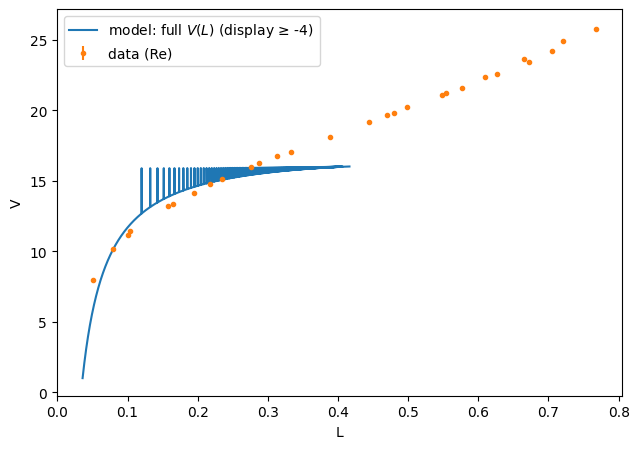

In [9]:

torch.set_grad_enabled(True)

# ----- differentiable real-branch interpolator (uses current model) -----
def V_of_L_interp_diff(model, L_query,
                       zmin=0.02, zmax=0.9997, zs_num=4000, q=2.7, eps=1e-12):
    dev, dt = model.a.device, model.a.dtype
    Lq = torch.as_tensor(L_query, dtype=dt, device=dev).reshape(-1)

    u  = torch.linspace(0.0, 1.0, zs_num, dtype=dt, device=dev)
    zs = zmin + (zmax - zmin) * (u**q)

    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]
    dL = torch.diff(Lc)
    keep = torch.cat([torch.tensor([True], device=dev), dL > 0])
    Lm, Vm = Lc[keep], Vc[keep]

    # interp + linear extrapolation (we will avoid using extrapolated points in loss)
    pos = torch.searchsorted(Lm, Lq, right=True)
    i0 = (pos-1).clamp(0, Lm.numel()-2); i1 = i0+1
    x0, x1 = Lm[i0], Lm[i1]
    y0, y1 = Vm[i0], Vm[i1]
    w  = (Lq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w*(y1-y0)
    mL = (Vm[1]-Vm[0])/(Lm[1]-Lm[0]+eps)
    mR = (Vm[-1]-Vm[-2])/(Lm[-1]-Lm[-2]+eps)
    v_left  = Vm[0]  + mL*(Lq - Lm[0])
    v_right = Vm[-1] + mR*(Lq - Lm[-1])
    v = torch.where(Lq <  Lm[0],  v_left,  v_lin)
    v = torch.where(Lq >  Lm[-1], v_right, v)

    return v, (Lm[0].detach(), Lm[-1].detach())   # v is FULL V (no shift)

# ----- regularizers -----
def smoothness_C2(val_fn, z):
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()

def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995,  dtype=model.a.dtype, device=model.a.device)
    f0   = model.eval_f(z0).real
    g0   = model.eval_g(z0).real
    fhor = model.eval_f(zh).real
    return (f0-1.0)**2 + (g0-1.0)**2 + (fhor-0.0)**2

# ----- tiny kick so grads aren’t dead -----
with torch.no_grad():
    if torch.allclose(model.a, torch.zeros_like(model.a)): model.a.normal_(0.0, 5e-4)
    if torch.allclose(model.b, torch.zeros_like(model.b)): model.b.normal_(0.0, 5e-4)

loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10, shuffle=True, drop_last=False)

opt = torch.optim.AdamW([
    {'params': [model.a],      'lr': 2e-2,  'weight_decay': 5e-5},
    {'params': [model.b],      'lr': 8e-3,  'weight_decay': 5e-5},
    {'params': [model.shift],  'lr': 6e-2,  'weight_decay': 0.0},
    {'params': [model.logcoef],'lr': 6e-4,  'weight_decay': 0.0},
], betas=(0.9, 0.999))
EPOCHS = 100
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=2e-4)

# reg weights
lam_a_L2, lam_b_L2 = 4e-4, 6e-4
lam_a_C2, lam_b_C2 = 9e-4, 7e-4
lam_phy = 3e-3
z_reg  = torch.linspace(1e-3, 0.99, 220, dtype=model.a.dtype, device=model.a.device)

# snapshots (optional)
snap_every = max(1, EPOCHS // 40)
snap_a, snap_b, snap_coef, snap_shift = [], [], [], []
def _snap():
    snap_a.append(model.a.detach().cpu().numpy().copy())
    snap_b.append(model.b.detach().cpu().numpy().copy())
    snap_coef.append(model.logcoef.exp().item())
    snap_shift.append(model.shift.item())
_snap()

eps = 1e-12
for epoch in range(1, EPOCHS+1):
    for L, V, sigma in loader:
        opt.zero_grad()

        # model at these L (FULL V, no shift) + the real-branch support this epoch
        V_core, (Lmin_sup, Lmax_sup) = V_of_L_interp_diff(model, L, zs_num=4000)
        # mask: only use points inside the current support to avoid extrap bias
        m = (L >= Lmin_sup) & (L <= Lmax_sup)
        if m.sum() == 0:
            continue

        V_pred = V_core[m] + model.shift
        r_re   = V_pred - V.real[m]

        # weights
        w_re = torch.clamp(1.0/(sigma.real[m]**2 + eps), max=1e6)
        wL   = (L[m] / dataset.L.max()).clamp_min(0).pow(1.5)

        loss_re = (w_re * wL * r_re**2).mean()
        reg_L2  = lam_a_L2*(model.a.real**2).sum() + lam_b_L2*(model.b.real**2).sum()
        reg_C2  = lam_a_C2*smoothness_C2(model.eval_a, z_reg) + lam_b_C2*smoothness_C2(model.eval_b, z_reg)
        reg_phy = lam_phy * uv_horizon_penalty(model)

        loss = loss_re + reg_L2 + reg_C2 + reg_phy
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # small calibration nudge for shift (uses same mask/weights)
        with torch.no_grad():
            num = (w_re*wL * (V.real[m] - V_core[m])).sum()
            den = (w_re*wL).sum().clamp_min(1e-8)
            target_shift = (num/den).item()
            model.shift.add_(0.25 * (target_shift - model.shift.item()))

    sched.step()
    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch {epoch:3d} | loss={loss.item():.4e} | shift={model.shift.item():.3f} | coef={model.logcoef.exp().item():.3e}")
    if epoch % snap_every == 0 or epoch == EPOCHS:
        _snap()

# ---- final plot: real branch vs data (Re). Clip display at V >= -4 to avoid UV blowup on screen.
with torch.no_grad():
    zs = torch.linspace(0.06, 0.999, 3000, dtype=model.a.dtype, device=model.a.device)
    L_curve = model.integrate_L(zs).real
    V_curve = model.integrate_V(zs).real + model.shift
    idx = torch.argsort(L_curve)
    Ls, Vs = L_curve[idx], V_curve[idx]
    keep = torch.cat([torch.tensor([True], device=Ls.device), torch.diff(Ls) > 0])
    Ls, Vs = Ls[keep], Vs[keep]
    # display-only clamp
    Vs_display = torch.maximum(Vs, torch.tensor(-4.0, dtype=Vs.dtype, device=Vs.device))

plt.figure(figsize=(6.5,4.6))
plt.plot(Ls.cpu().numpy(), Vs_display.cpu().numpy(), '-', label='model: full $V(L)$ (display ≥ -4)')
plt.errorbar(dataset.L.cpu().numpy(), dataset.V.real.cpu().numpy(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None),
             fmt='.', label='data (Re)')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.tight_layout()


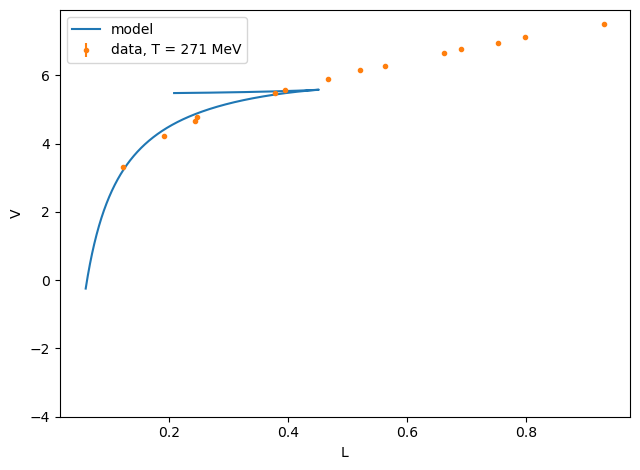

In [10]:
with torch.no_grad():
    zs = torch.linspace(0.10, 0.995, 1200, dtype=model.a.dtype, device=model.a.device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift  # constant disconnected via shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lc.cpu(), Vc.cpu(), '-', label='model')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='.', label='data, T = 271 MeV')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()


Plot parameters

Final shift = 0.5144,  coef = 0.231164


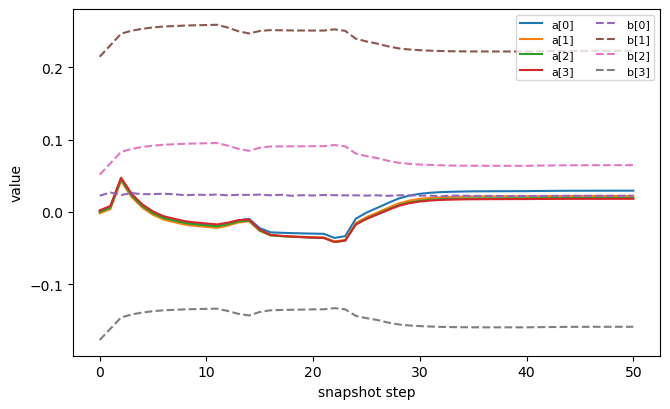

In [15]:


sa, sb = np.array(snap_a), np.array(snap_b)
plt.figure(figsize=(6.8,4.2))
for i in range(sa.shape[1]):
    plt.plot(sa[:,i], label=f'a[{i}]')
for i in range(sb.shape[1]):
    plt.plot(sb[:,i], '--', label=f'b[{i}]')
plt.xlabel('snapshot step'); plt.ylabel('value'); plt.legend(ncol=2, fontsize=8); plt.tight_layout()

print(f"Final shift = {model.shift.item():.4f},  coef = {model.logcoef.exp().item():.6g}")


In [13]:
# ==== Print final a_i, b_i coefficients ====

@torch.no_grad()
def print_ab(model):
    a = model.a.detach().cpu().numpy()
    b = model.b.detach().cpu().numpy()

    # Plain readable print
    print("a:", ", ".join([f"a{i} = {a[i]:.10g}" for i in range(len(a))]))
    print("b:", ", ".join([f"b{i} = {b[i]:.10g}" for i in range(len(b))]))

    # Mathematica-friendly rows (copy/paste)
    print("\n(* Mathematica lists *)")
    print("{", ", ".join([f"{x:.17g}" for x in a]), "},  (* a0..aN *)")
    print("{", ", ".join([f"{x:.17g}" for x in b]), "},  (* b0..bN *)")

print_ab(model)


a: a0 = 0.02927287119, a1 = 0.02204302884, a2 = 0.01925319473, a3 = 0.01799684028
b: b0 = 0.02232127433, b1 = 0.2228583333, b2 = 0.06460651681, b3 = -0.1590441493

(* Mathematica lists *)
{ 0.029272871188244811, 0.02204302883869607, 0.019253194725121634, 0.017996840281472023 },  (* a0..aN *)
{ 0.022321274330828762, 0.22285833325388796, 0.064606516812609052, -0.15904414925111368 },  (* b0..bN *)


# Export the results

Export (print) real-branch table for Mathematica


Columns per row: { z_*, f(z_*), g(z_*), L(z_*), V(z_*) }


V includes the model's learned shift (set include_shift=False to omit).

In [20]:



@torch.no_grad()
def print_real_table_for_mathematica(model, zmin=0.01, zmax=0.99, N=100, include_shift=True):
    dev, dt = model.a.device, model.a.dtype

    # grid of real z_*
    zs = torch.linspace(zmin, zmax, N, dtype=dt, device=dev)

    # columns
    fz = model.eval_f(zs).real
    gz = model.eval_g(zs).real
    Lz = model.integrate_L(zs).real
    Vz = model.integrate_V(zs).real
    if include_shift:
        Vz = Vz + model.shift

    # print Mathematica-style rows
    # (use enough precision but not crazy long; adjust fmt if you like)
    zs_np = zs.cpu().numpy()
    f_np  = fz.cpu().numpy()
    g_np  = gz.cpu().numpy()
    L_np  = Lz.cpu().numpy()
    V_np  = Vz.cpu().numpy()

    # emit one row per line, ending with a comma
    for i in range(N):
        print("{ ", 
              f"{zs_np[i]:.17g} ,",
              f"{f_np[i]:.17g} ,",
              f"{g_np[i]:.17g} ,",
              f"{L_np[i]:.17g} ,",
              f"{V_np[i]:.17g} ",
              "},", sep='')

# ---- run it ----
print_real_table_for_mathematica(model, zmin=0.01, zmax=0.99, N=100, include_shift=True)


{ 0.01 ,0.9999586705439889 ,1.0000589302478349 ,0.0038181209880315302 ,-91.25108613260133 },
{ 0.019898989898989899 ,0.99984873803743868 ,1.0001561823907792 ,0.0075977170403663738 ,-43.712268003390214 },
{ 0.029797979797979796 ,0.99966890153731336 ,1.0002936445252315 ,0.011377280578775885 ,-27.760286546371159 },
{ 0.039696969696969696 ,0.99941772169837062 ,1.0004730771522412 ,0.015156736159394 ,-19.76530611876403 },
{ 0.049595959595959596 ,0.99909355124302879 ,1.0006965161498451 ,0.018936006330262187 ,-14.962861651958185 },
{ 0.059494949494949489 ,0.9986945364395855 ,1.0009662739016412 ,0.022715011076643837 ,-11.759404763012011 },
{ 0.069393939393939397 ,0.99821861883619301 ,1.0012849406673492 ,0.026493667276952283 ,-9.4706635155952146 },
{ 0.07929292929292929 ,0.99766353725569257 ,1.0016553862261424 ,0.030271888163289809 ,-7.7540648544692861 },
{ 0.089191919191919183 ,0.99702683005601522 ,1.0020807618282488 ,0.034049582792939043 ,-6.4191215042048348 },
{ 0.099090909090909091 ,0.996305

# Add the complex branch in the training (full training but with complex branch of zs)

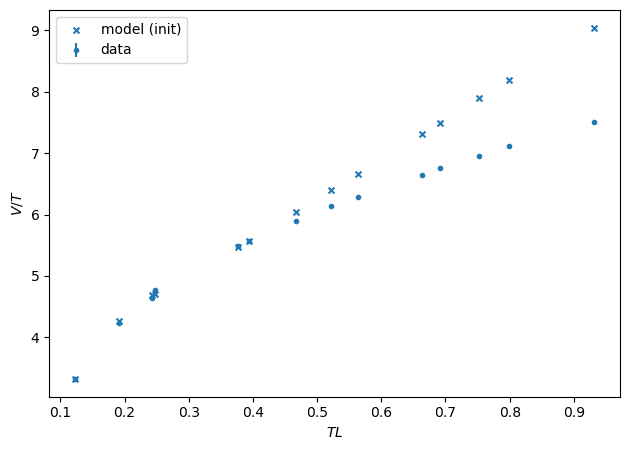

In [11]:
# --- Init plot: uses model.forward, which relies on complex-capable integrate_L/V ----
with torch.no_grad():
    V_now = model(dataset.L).real  # model.forward -> V_of_L_interp -> integrate_L (complex)

plt.figure(figsize=(6.4,4.6))
plt.errorbar(dataset.L.cpu().numpy(), dataset.V.real.cpu().numpy(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None),
             fmt='.', label='data')
plt.scatter(dataset.L.cpu().numpy(), V_now.cpu().numpy(), s=18, marker='x', label='model (init)')
plt.xlabel(r'$TL$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()


ep   1 | loss=6.3209e+04 | Re=6.3209e+04 | L2=7.89e-06 C2=3.66e-14 PHY=1.21e-06 | shift=5.730 coef=2.478e-01
ep  10 | loss=1.0884e+04 | Re=1.0884e+04 | L2=1.10e-05 C2=2.12e-13 PHY=1.18e-06 | shift=6.244 coef=2.482e-01
ep  20 | loss=5.0908e+03 | Re=5.0908e+03 | L2=1.74e-05 C2=3.10e-13 PHY=1.18e-06 | shift=6.721 coef=2.498e-01
ep  30 | loss=3.5663e+03 | Re=3.5663e+03 | L2=1.39e-05 C2=2.88e-13 PHY=1.18e-06 | shift=6.337 coef=2.509e-01
ep  40 | loss=3.1812e+03 | Re=3.1812e+03 | L2=1.89e-05 C2=3.65e-13 PHY=1.19e-06 | shift=6.401 coef=2.526e-01
ep  50 | loss=1.5399e+03 | Re=1.5399e+03 | L2=1.74e-05 C2=3.52e-13 PHY=1.19e-06 | shift=6.408 coef=2.535e-01
ep  60 | loss=2.2875e+03 | Re=2.2875e+03 | L2=1.74e-05 C2=3.75e-13 PHY=1.18e-06 | shift=6.686 coef=2.548e-01
ep  70 | loss=2.3781e+03 | Re=2.3781e+03 | L2=1.93e-05 C2=4.06e-13 PHY=1.18e-06 | shift=7.242 coef=2.556e-01
ep  80 | loss=5.6388e+02 | Re=5.6388e+02 | L2=2.27e-05 C2=4.54e-13 PHY=1.18e-06 | shift=7.471 coef=2.561e-01
ep  90 | loss=9.098

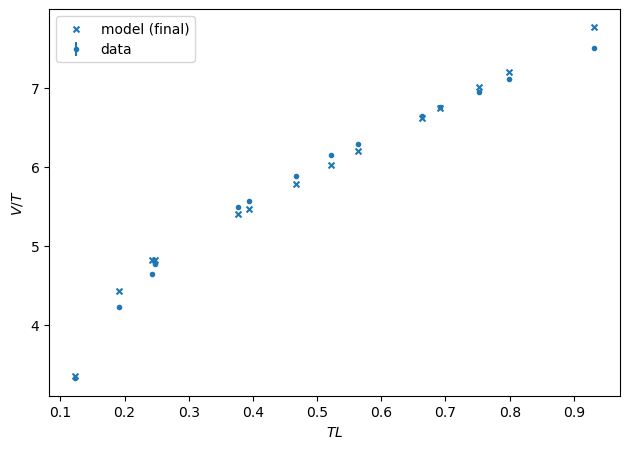

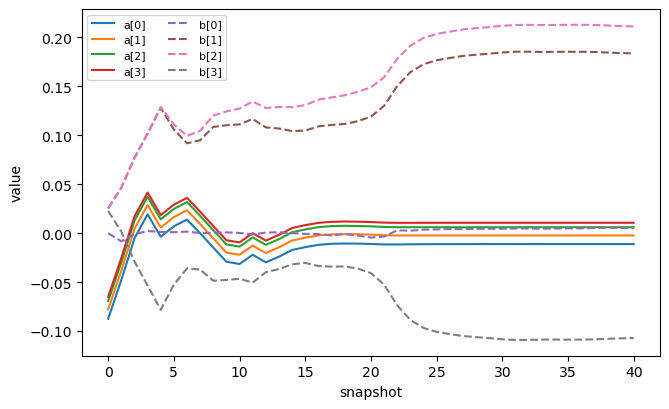

In [12]:

torch.set_grad_enabled(True)

# ---------- priors / regularizers ----------
def smoothness_C2(val_fn, z):
    v = val_fn(z)
    d2 = v[:-2] - 2*v[1:-1] + v[2:]
    return (d2.real**2).mean()

def uv_horizon_penalty(model):
    z0 = torch.tensor(1e-3,  dtype=model.a.dtype, device=model.a.device)
    zh = torch.tensor(0.995,  dtype=model.a.dtype, device=model.a.device)
    f0   = model.eval_f(z0).real
    g0   = model.eval_g(z0).real
    fhor = model.eval_f(zh).real
    # soft targets: AdS–BH UV and a vanishing f near the horizon
    return (f0-1)**2 + (g0-1)**2 + (fhor-0)**2

# ---------- dataloader ----------
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10, shuffle=True, drop_last=False)

# ---------- optimizer & schedule ----------
opt = torch.optim.AdamW([
    {'params': [model.a],      'lr': 1.2e-2, 'weight_decay': 6e-5},
    {'params': [model.b],      'lr': 7.0e-3, 'weight_decay': 6e-5},
    {'params': [model.logcoef],'lr': 8.0e-4, 'weight_decay': 0.0},
    {'params': [model.shift],  'lr': 3.0e-2, 'weight_decay': 0.0},  # let vertical offset move
], betas=(0.9,0.999))

EPOCHS = 160
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=2e-4)

# ---------- regularization weights ----------
lam_a_L2, lam_b_L2 = 4e-4, 6e-4
lam_a_C2, lam_b_C2 = 9e-4, 7e-4
lam_phy            = 3e-3
z_reg = torch.linspace(1e-3, 0.99, 220, dtype=model.a.dtype, device=model.a.device)

# ---------- optional imaginary term (off now; can turn on later) ----------
USE_IMAG = False

# ---------- snapshots for monitoring ----------
snap_every = max(1, EPOCHS // 40)
snap_a, snap_b, snap_coef, snap_shift = [], [], [], []

def snapshot():
    snap_a.append(model.a.detach().cpu().numpy().copy())
    snap_b.append(model.b.detach().cpu().numpy().copy())
    snap_coef.append(model.logcoef.exp().item())
    snap_shift.append(model.shift.item())

snapshot()

# ---------- training ----------
eps = 1e-12
for ep in range(1, EPOCHS+1):
    for L, V, sigma in loader:
        opt.zero_grad()

        # Single call: forward -> V_of_L_interp (parametric sampling with complex-capable integrals)
        V_pred_c = model(L)                      # complex dtype, imag ~ 0 for now
        V_pred   = V_pred_c.real                 # we train to Re data first

        # data residuals
        r_re = V_pred - V.real
        if USE_IMAG:
            r_im = (V_pred_c.imag - V.imag)
        else:
            r_im = torch.zeros_like(r_re)

        # weights (use provided sigma, mild large-L emphasis)
        w_re = torch.clamp(1.0/(sigma.real**2 + eps), max=1e6)
        wL   = (L / dataset.L.max()).clamp_min(0).pow(1.25)

        loss_re = (w_re * wL * r_re**2).mean()
        loss_im = 0.0 * (r_im**2).mean()

        # priors/regularizers
        reg_L2 = lam_a_L2*(model.a.real**2).sum() + lam_b_L2*(model.b.real**2).sum()
        reg_C2 = lam_a_C2*smoothness_C2(model.eval_a, z_reg) + lam_b_C2*smoothness_C2(model.eval_b, z_reg)
        reg_phy = lam_phy * uv_horizon_penalty(model)

        loss = loss_re + loss_im + reg_L2 + reg_C2 + reg_phy
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # small one-line calibration nudge for the shift (faster vertical alignment)
        with torch.no_grad():
            num = (w_re*wL * (V.real - (V_pred - model.shift))).sum()
            den = (w_re*wL).sum().clamp_min(1e-8)
            target_shift = (num/den).item()
            model.shift.add_(0.25 * (target_shift - model.shift.item()))

    sched.step()
    if ep % 10 == 0 or ep == 1:
        print(f"ep {ep:3d} | loss={loss.item():.4e} | Re={loss_re.item():.4e} | "
              f"L2={reg_L2.item():.2e} C2={reg_C2.item():.2e} PHY={reg_phy.item():.2e} | "
              f"shift={model.shift.item():.3f} coef={model.logcoef.exp().item():.3e}")

    if ep % snap_every == 0 or ep == EPOCHS:
        snapshot()

# ---------- final plot ----------
with torch.no_grad():
    V_fit = model(dataset.L).real

plt.figure(figsize=(6.4,4.6))
plt.errorbar(dataset.L.cpu().numpy(), dataset.V.real.cpu().numpy(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None),
             fmt='.', label='data')
plt.scatter(dataset.L.cpu().numpy(), V_fit.cpu().numpy(), s=18, marker='x', label='model (final)')
plt.xlabel(r'$TL$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()

# ---------- parameter traces (optional) ----------
sa, sb = np.array(snap_a), np.array(snap_b)
plt.figure(figsize=(6.8,4.2))
for i in range(sa.shape[1]): plt.plot(sa[:,i], label=f'a[{i}]')
for i in range(sb.shape[1]): plt.plot(sb[:,i], '--', label=f'b[{i}]')
plt.xlabel('snapshot'); plt.ylabel('value'); plt.legend(ncol=2, fontsize=8); plt.tight_layout()
print(f"Final shift={model.shift.item():.4f}, coef={model.logcoef.exp().item():.6g}")


In [18]:
print(V_fit.cpu().numpy(),L_fit.cpu().numpy())

[3.34892503 4.43389365 4.82267165 4.81872892 5.39871863 5.47127177
 5.78497984 6.01846431 6.19680546 6.62445613 6.74587476 7.00888436
 7.2047825  7.7756715 ] [0.12302962 0.19184942 0.24297428 0.24687729]


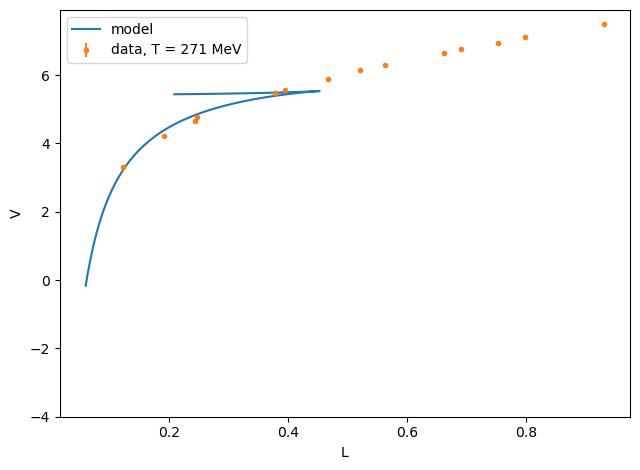

In [13]:
with torch.no_grad():
    zs = torch.linspace(0.10, 0.995, 1200, dtype=model.a.dtype, device=model.a.device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift  # constant disconnected via shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lc.cpu(), Vc.cpu(), '-', label='model')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='.', label='data, T = 271 MeV')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()

In [14]:

import math
dev, dt = model.a.device, model.a.dtype

# Use your original complex-capable integrals
def L_of(zs): return model.integrate_L(zs)      # complex -> complex
def V_of(zs): return model.integrate_V(zs)      # complex -> complex (no shift added)

# --- robust scalar Newton in z* = u + i v for a target L ---
def newton_for_L(L_target, z_init, maxit=35, tol=1e-11, lam=0.6):
    """
    Solve F(z*) = [Re L(z*) - L_target, Im L(z*)] = 0 by damped Newton.
    z_init: complex scalar (torch or python complex).
    Returns (z_sol: complex, ok: bool).
    """
    if not isinstance(z_init, torch.Tensor):
        z = torch.tensor(complex(z_init), dtype=torch.complex128, device=dev, requires_grad=True)
    else:
        z = z_init.clone().detach().to(torch.complex128).requires_grad_(True)

    Lt = torch.tensor(float(L_target), dtype=dt, device=dev)

    for _ in range(maxit):
        Lc = L_of(z)
        if Lc.ndim: Lc = Lc.squeeze()
        F1 = Lc.real - Lt   # scalar
        F2 = Lc.imag        # scalar

        res = torch.hypot(F1, F2).detach().item()
        if res < tol:
            return complex(z.detach().cpu().numpy()), True

        # z = u + i v, treat u,v as real vars
        u = torch.view_as_real(z)[0] ; v = torch.view_as_real(z)[1]
        # make z from (u,v) for Jacobian
        z_rebuild = torch.complex(u, v)
        Lc2 = L_of(z_rebuild)
        if Lc2.ndim: Lc2 = Lc2.squeeze()
        F1s = Lc2.real - Lt
        F2s = Lc2.imag

        # J = dF/d(u,v)
        (dF1_du, dF1_dv) = torch.autograd.grad(F1s, (u, v), retain_graph=True,  allow_unused=True)
        (dF2_du, dF2_dv) = torch.autograd.grad(F2s, (u, v), retain_graph=False, allow_unused=True)
        z0 = torch.zeros((), dtype=dt, device=dev)
        dF1_du = dF1_du if dF1_du is not None else z0
        dF1_dv = dF1_dv if dF1_dv is not None else z0
        dF2_du = dF2_du if dF2_du is not None else z0
        dF2_dv = dF2_dv if dF2_dv is not None else z0
        J = torch.stack([torch.stack([dF1_du, dF1_dv]),
                         torch.stack([dF2_du, dF2_dv])])
        F = torch.stack([F1s.detach(), F2s.detach()])  # use values from (u,v)

        try:
            delta = torch.linalg.solve(J, -F)
        except RuntimeError:
            delta = torch.linalg.solve(J + 1e-9*torch.eye(2, dtype=dt, device=dev), -F)

        u_new = (u + lam*delta[0]).detach()
        v_new = (v + lam*delta[1]).detach()

        # backtracking if residual worsens
        z_try = torch.complex(u_new, v_new).requires_grad_(True)
        L_try = L_of(z_try)
        if L_try.ndim: L_try = L_try.squeeze()
        res_try = torch.hypot(L_try.real - Lt, L_try.imag).detach().item()
        if (not math.isfinite(res_try)) or (res_try > 10*res):
            u_new = (u + 0.3*lam*delta[0]).detach()
            v_new = (v + 0.3*lam*delta[1]).detach()

        z = torch.complex(u_new, v_new).requires_grad_(True)

    return complex(z.detach().cpu().numpy()), False

@torch.no_grad()
def real_branch():
    # dense z*∈(0,1) → parametric (L,V), keep monotone part
    zs = torch.linspace(0.02, 0.999, 2200, dtype=dt, device=dev)
    Lc = L_of(zs).real ; Vc = V_of(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc, zs = Lc[idx], Vc[idx], zs[idx]
    keep = torch.cat([torch.tensor([True], device=dev), torch.diff(Lc) > 0])
    return Lc[keep], Vc[keep], zs[keep]

# 1) get the real branch & splice point
with torch.no_grad():
    Lr, Vr, zsr = real_branch()
    coef = model.logcoef.exp()
    V_real = Vr*coef + model.shift
    Lmax = float(Lr[-1].item())
    z_turn = complex(zsr[-1].item())

# 2) choose tail targets = ALL data L beyond Lmax (this is what you want)
L_tail_targets = dataset.L[dataset.L > Lmax]
if L_tail_targets.numel() == 0:
    print("No data beyond L_max — nothing to continue.")
    zs_tail = torch.empty(0, dtype=torch.complex128, device=dev)
else:
    # continuation: seed z with small positive Im to pick the physical sheet
    z_seed = z_turn + 0.08j
    zs_tail_list = []
    ok = True
    for Lt in L_tail_targets.detach().cpu().tolist():
        # try a couple of η and damping values if first attempt fails
        z_here, okN = newton_for_L(Lt, z_seed, maxit=45, tol=1e-11, lam=0.6)
        if not okN:
            for eta in (0.10, 0.12, 0.15):
                z_try, okN = newton_for_L(Lt, z_turn + 1j*eta, maxit=55, tol=1e-11, lam=0.45)
                if okN: 
                    z_here = z_try
                    break
        if not okN:
            ok = False
            print(f"[warn] could not continue to L={Lt:.4f}; stopping tail here.")
            break
        zs_tail_list.append(z_here)
        z_seed = z_here  # continuation seed

    zs_tail = torch.tensor(zs_tail_list, dtype=torch.complex128, device=dev) if ok else \
              torch.tensor(zs_tail_list, dtype=torch.complex128, device=dev)

# 3) store curve the same way your old code did
with torch.no_grad():
    model.curve_L  = [0.0] + Lr.cpu().tolist()
    model.curve_zs = [0.0+0.0j] + zsr.cpu().numpy().tolist()
    if zs_tail.numel():
        L_tail = L_of(zs_tail).real
        idx = torch.argsort(L_tail)
        L_tail = L_tail[idx]
        V_tail = (V_of(zs_tail).real*coef + model.shift)[idx]
        model.curve_L  += L_tail.cpu().tolist()
        model.curve_zs += zs_tail[idx].cpu().numpy().tolist()


[warn] could not continue to L=0.4674; stopping tail here.


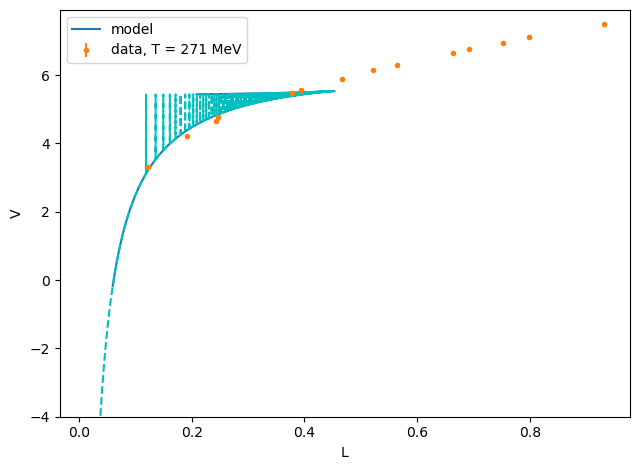

In [15]:
with torch.no_grad():
    zs = torch.linspace(0.10, 0.995, 1200, dtype=model.a.dtype, device=model.a.device)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift  # constant disconnected via shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lc.cpu(), Vc.cpu(), '-', label='model')
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(), yerr=dataset.sigma.real.cpu(),
             fmt='.', label='data, T = 271 MeV')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()


zs = np.linspace(0.25, 0.99, 50)
#d_L = np.array([dataset.integrate_L(z).real for z in zs])
#d_V = np.array([dataset.integrate_V(z).real for z in zs])
#plt.plot([np.real(model.integrate_L(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],[model.shift.detach().numpy()+np.real(model.integrate_V(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],'c-',label='model')
plt.plot([np.real(model.integrate_L(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))],[model.shift.detach().numpy()+np.real(model.integrate_V(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))],'c--')
plt.ylabel('V')
plt.xlabel('L')
#plt.plot(d_L,d_V)
#plt.plot([np.real(dataset.integrate_L(model.curve_zs[i])) for i in range(1,len(model.curve_zs))],[np.real(dataset.integrate_V(model.curve_zs[i])) for i in range(1,len(model.curve_zs))])
plt.ylabel('V')
plt.xlabel('L')
plt.legend();


In [ ]:
# === Complex continuation: build model.curve_L and model.curve_zs (real + complex tail) ===
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_grad_enabled(True)  # autograd for the Jacobian

dev, dt = model.a.device, model.a.dtype

# --- convenience wrappers (always return complex tensors) ---
def L_of_zstar(zs):   # complex -> complex
    return model.integrate_L(zs)          # your complex-safe integral (has i*eps sheet selector)

def V_of_zstar(zs):   # complex -> complex (NO shift here)
    return model.integrate_V(zs)

# --- sample real branch: monotone part only (gives L_max and z_turn) ---
@torch.no_grad()
def sample_real_branch(zmin=0.02, zmax=0.9992, Nc=2000):
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = L_of_zstar(zs).real
    Vc = V_of_zstar(zs).real
    idx = torch.argsort(Lc)
    Lc, Vc, zs = Lc[idx], Vc[idx], zs[idx]
    keep = torch.cat([torch.tensor([True], device=dev), torch.diff(Lc) > 0])
    return Lc[keep], Vc[keep], zs[keep]

# --- robust damped Newton in (u,v) for Re L = L_t, Im L = 0 ---
def newton_uv_for_L(L_target: float, u0: float, v0: float, maxit=30, tol=1e-11, lam=0.7):
    """
    Solve Re L(u+iv) = L_target, Im L(u+iv) = 0
    with a damped Newton step and simple backtracking.
    Returns (u, v, ok).
    """
    # variables with grad
    u = torch.tensor(float(u0), dtype=dt, device=dev, requires_grad=True)
    v = torch.tensor(float(v0), dtype=dt, device=dev, requires_grad=True)
    L_t = torch.tensor(float(L_target), dtype=dt, device=dev)

    for _ in range(maxit):
        zc = torch.complex(u, v)             # scalar complex
        Lc = L_of_zstar(zc)                  # complex scalar

        # scalar residuals
        F1 = (Lc.real - L_t)                 # shape: []
        F2 = (Lc.imag)                       # shape: []

        # residual norm for stopping (detach for the test)
        res = torch.sqrt(F1*F1 + F2*F2).detach().item()
        if res < tol:
            return float(u.detach()), float(v.detach()), True

        # Jacobian entries (take grads of scalars wrt scalars to avoid shape mismatches)
        dF1_du, = torch.autograd.grad(F1, u, retain_graph=True,  allow_unused=True)
        dF1_dv, = torch.autograd.grad(F1, v, retain_graph=True,  allow_unused=True)
        dF2_du, = torch.autograd.grad(F2, u, retain_graph=True,  allow_unused=True)
        dF2_dv, = torch.autograd.grad(F2, v, retain_graph=False, allow_unused=True)

        # guard Nones
        z0 = torch.zeros((), dtype=dt, device=dev)
        dF1_du = dF1_du if dF1_du is not None else z0
        dF1_dv = dF1_dv if dF1_dv is not None else z0
        dF2_du = dF2_du if dF2_du is not None else z0
        dF2_dv = dF2_dv if dF2_dv is not None else z0

        # solve J * delta = -F
        J = torch.stack([
            torch.stack([dF1_du, dF1_dv]),
            torch.stack([dF2_du, dF2_dv]),
        ])   # (2,2)
        F = torch.stack([F1, F2])            # (2,)

        try:
            delta = torch.linalg.solve(J, -F)
        except RuntimeError:
            Jreg = J + 1e-9 * torch.eye(2, dtype=dt, device=dev)
            delta = torch.linalg.solve(Jreg, -F)

        # damped step + quick backtracking if residual increases a lot
        u_new = (u + lam * delta[0]).detach().requires_grad_(True)
        v_new = (v + lam * delta[1]).detach().requires_grad_(True)

        zc_try = torch.complex(u_new, v_new)
        L_try  = L_of_zstar(zc_try)
        res_try = torch.sqrt((L_try.real - L_t)**2 + (L_try.imag)**2).detach().item()

        if (not math.isfinite(res_try)) or (res_try > 10*res):
            u_new = (u + 0.3 * lam * delta[0]).detach().requires_grad_(True)
            v_new = (v + 0.3 * lam * delta[1]).detach().requires_grad_(True)

        u, v = u_new, v_new

    return float(u.detach()), float(v.detach()), False

# --- build curve_zs: real branch + complex tail at data L > L_max -----------
with torch.no_grad():
    # real branch
    Lr, Vr, zsr = sample_real_branch()
    L_max  = float(Lr[-1].item())
    z_turn = float(zsr[-1].real.item())

# choose target L's: prefer *data* beyond L_max; fallback to a uniform grid
L_tail_targets = dataset.L[dataset.L > L_max]
if L_tail_targets.numel() == 0:
    # make a simple grid if no data beyond L_max
    L_tail_targets = torch.linspace(L_max + 0.01, min(L_max + 0.35, 0.95), 60, dtype=dt, device=dev)
L_tail_targets = L_tail_targets.detach().cpu().numpy().tolist()

# continuation seeds
u_seed, v_seed = z_turn, 0.06  # small +imag to pick physical sheet

zs_tail = []
ok = True
for Lt in L_tail_targets:
    u_sol, v_sol, ok_this = newton_uv_for_L(float(Lt), u_seed, v_seed, maxit=35, tol=1e-11, lam=0.7)
    if not ok_this:
        ok = False
        break
    zs_tail.append(u_sol + 1j*v_sol)
    u_seed, v_seed = u_sol, v_sol  # continuation: reuse last root

zs_tail = torch.tensor(zs_tail, dtype=torch.complex128, device=dev) if zs_tail else torch.empty(0, dtype=torch.complex128, device=dev)

# --- assemble curve and store on the model (like your original code) -------
with torch.no_grad():
    coef = model.logcoef.exp()
    V_real = Vr*coef + model.shift

    if zs_tail.numel():
        L_tail = L_of_zstar(zs_tail).real
        V_tail = V_of_zstar(zs_tail).real*coef + model.shift

        # sort tail by L (just in case) and splice after the real branch
        idx = torch.argsort(L_tail)
        L_full = torch.cat([Lr, L_tail[idx]])
        V_full = torch.cat([V_real, V_tail[idx]])
        zs_full = torch.cat([zsr, zs_tail[idx]])
    else:
        L_full, V_full, zs_full = Lr, V_real, zsr

    # store for reuse (mimic the "curve_zs" behavior you had)
    model.curve_L  = [float(x) for x in L_full.detach().cpu().numpy().tolist()]
    model.curve_zs = [complex(z.detach().cpu().numpy().item()) for z in zs_full]

# --- plot: real branch (solid) + complex tail (dashed) vs data -------------
plt.figure(figsize=(6.6,4.8))
plt.plot(Lr.detach().cpu().numpy(), V_real.detach().cpu().numpy(), '-',  lw=2.2, color='tab:orange', label='model (real branch)')
if zs_tail.numel():
    plt.plot(L_tail[idx].detach().cpu().numpy(), V_tail[idx].detach().cpu().numpy(), '--', lw=2.2, color='tab:green', label='model (complex tail, Re)')
plt.errorbar(dataset.L.cpu().numpy(), dataset.V.real.cpu().numpy(),
             yerr=np.clip(dataset.sigma.real.cpu().numpy(),0,None), fmt='.', label='data (Re)')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.tight_layout()

print(f"L_max (real) ≈ {L_max:.4f}  |  complex tail points: {len(zs_tail)}")
print(f"Stored: len(curve_L)={len(model.curve_L)}, len(curve_zs)={len(model.curve_zs)}")
